In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install tslearn
from tabulate import tabulate
from random import random
from random import seed

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

from google.colab import drive
drive.mount('/content/drive')
DATASET_PATH = '/content/drive/MyDrive/Project/AzureDataset_FunctionCalls/'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.5 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
#Prerequisites

import time


json_name = "33fe_15_min_ice90_7clust2"
remakeLength = 5
m=1
numClusters = 5
skip = True
shapeletType = "90"
movingWindow = True
old = False
save = False
# 'cluster', 'none', 'binning'
technique = 'none'
durationLength = '1m'
#names = ["restart","ratioReplace","clusterReplace","secondOrderMarkov","rngRemake","discreteMarkov","proportionalBinning","binning",'simpleCluster']
jsonType = "binning"
if old:
  csvName = '33fe3deb029c50d55a33489059339356df43b5078d2ea955572022b644c9caaa'
  #csvName = '36bc568292ec360f9cc2f4431fa0db953ce8714cdb1b165f4ec68ca54e7fe2be'
  #csvName = '14456d07da6db5da228beff3ad356f824e4cd09a8d6771089eb26a862526ac9a'
  #csvName = 'cd05d7b4445349ee645ea290586fd28c0c675a155eb1522485535c5c0329a908'
  multiSeriesMain = pd.read_csv(DATASET_PATH+csvName+'.csv')
  #multiSeriesMain = multiSeriesMain['bde06c0fbc47763c3c3612154de4a65e13988a6c8d7e0269baf89148a0fea9fa'].astype(float).reset_index(drop=True).T
  multiSeriesMain = multiSeriesMain.loc[:, ~multiSeriesMain.columns.str.contains('^Unnamed')].astype(float).reset_index(drop=True).T
  multiSeries = multiSeriesMain.iloc[:,1440:2880].T
  multiSeries = multiSeries.iloc[:,0:2]
  print(multiSeries)
else:
  df = pd.read_csv('/content/drive/MyDrive/Project/AzureDataset_FunctionCalls/'+'invocations_per_function_md.anon.d02.csv')
  multiSeriesMain = df.loc[df.HashFunction == '493e9b9b4a83f0284763a4d1b1f9b7a849ad0e6409f7c8b404cd20c91e000848'].T
  multiSeries = multiSeriesMain.iloc[4:]
  multiSeries = multiSeries.astype(float)
  multiSeries = multiSeries.reset_index(drop=True).T
  multiSeries.loc[len(multiSeries)] = multiSeries.iloc[0]
  multiSeries = multiSeries.T
  print(multiSeries)
dimensions = len(multiSeries.T)

# for i in [0,60,120,180,360,420,480,540,600,660,720,780,840,900,960,1020,1080,1140,1200,1260,1320,1380]:
#   multiSeries.iloc[i,0] = 0
#   multiSeries.iloc[i,1] = 0


      1968  1   
0      2.0   2.0
1      0.0   0.0
2      0.0   0.0
3      0.0   0.0
4      0.0   0.0
...    ...   ...
1435  10.0  10.0
1436   9.0   9.0
1437  11.0  11.0
1438   5.0   5.0
1439  13.0  13.0

[1440 rows x 2 columns]


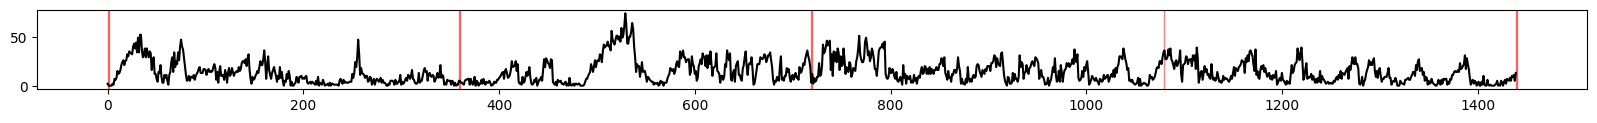

In [ ]:
# print(multiSeries.iloc[:,0])
# x=multiSeries.iloc[:,0]
# y=multiSeries.index
# plt.stem(x)
fig, ax = plt.subplots()
ax.axvspan(0, 1, color='red', alpha=0.5)
ax.axvspan(359, 360, color='red', alpha=0.5)
ax.axvspan(719, 720, color='red', alpha=0.5)
ax.axvspan(1079, 1080, color='red', alpha=0.5)
ax.axvspan(1439, 1440, color='red', alpha=0.5)
ax.set_aspect('equal')
ax.plot(multiSeries.iloc[:,0], color = "black")
plt.savefig('plot1.png', dpi=300)

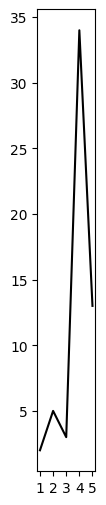

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.xticks([1,2,3,4,5])
ax.plot([1,2,3,4,5],[multiSeries.iloc[0,0],multiSeries.iloc[359,0],multiSeries.iloc[719,0],multiSeries.iloc[1079,0],multiSeries.iloc[1439,0]], color = 'black')
plt.savefig('plot1.png', dpi=300)

In [ ]:
#Binning
def custom_bin_counter(x,y,k=10,solo=False):
    q75, q25 = np.percentile(x, [75 ,25], axis=0)
    iqr = q75 - q25
    h = (2 * iqr) / ((x.shape[0])**(1/3))
    print(h)
    if solo:
      h = [h]
    for i in range(len(h)):
        if h[i] == 0:
            h[i] = 1

    t = {}
    mins = x.min(axis=0)
    maxs = x.max(axis=0)
    if solo:
      mins = [mins]
      maxs = [maxs]

    total_bins = 1
    for i in range(len(h)):
        total_bins *= (maxs[i]-mins[i])/h[i]

    def get_bin_name(point):
        point = point - mins
        bin = [int(p/h[i]) for i,p in enumerate(point)]
        return bin

    binList = []

    for p in x:
      b = tuple(get_bin_name(p))
      binList.append(b)
      if b not in t:
          t[b] = 0
      t[b] += 1

    binIndexDict = {}
    for key in t:
      binIndexDict[key] = [i for i, x in enumerate(binList) if x==key]
    binWindowDict = {}
    for key in t:
      temp = []
      for index in binIndexDict[key]:
        temp.append(x[index])
      binWindowDict[key] = temp




    k_keys_sorted = sorted(t, key=t.get, reverse=True)[:k]

    x_counter = 0
    for k in k_keys_sorted:
        x_counter += t[k]

    y_counter = 0
    for j in y:
        b = tuple(get_bin_name(j))
        if b in k_keys_sorted:
            y_counter += 1
    if solo:
      return (x_counter/x.shape[0], y_counter/y.shape[0],total_bins, binIndexDict, binWindowDict, k_keys_sorted,)
    else:
      return (x_counter/x.shape[0], y_counter/y.shape[0], total_bins, x.shape[1], binIndexDict, binWindowDict, k_keys_sorted,)


train_data = multiSeries.sort_index().values#.transpose()
test_data = multiSeries.sort_index().values#.transpose()
solo = False
if solo:
  train_coverage, test_coverage, total_bins, binIndexDict, binWindowDict, binKeys = custom_bin_counter(train_data, test_data, 10, solo)
else:
  train_coverage, test_coverage, total_bins, dim, binIndexDict, binWindowDict, binKeys = custom_bin_counter(train_data, test_data, 10)
print(train_coverage, test_coverage, total_bins)


binList = []
for binkey in binKeys:
  binList.append(binWindowDict[binkey])

binIndices = []
for binkey in binKeys:
  binIndices.append(binIndexDict[binkey])

print(binList)
print(binIndices)
binCentroid = []
if(shapeletType == "Centroid"):
  for d in range(len(binList[0][0])):
    tempBin = []
    for i in binList:
      tempBin.append(round(i[0][d]))
    binCentroid.append(tempBin)
if(shapeletType == "Maximal"):
  for d in range(len(binList[0][0])):
    tempBin = []
    for i in binList:
      tempMax = 0
      for l in i:
        if l[d] >= tempMax:
          tempMax = round(l[d])
      tempBin.append(tempMax)
    binCentroid.append(tempBin)
print(binCentroid)

[2.83375618 2.83375618]
0.8763888888888889 0.8763888888888889 681.9279286926536
[[array([4., 4.]), array([3., 3.]), array([3., 3.]), array([5., 5.]), array([5., 5.]), array([5., 5.]), array([3., 3.]), array([3., 3.]), array([4., 4.]), array([5., 5.]), array([5., 5.]), array([4., 4.]), array([4., 4.]), array([3., 3.]), array([3., 3.]), array([3., 3.]), array([3., 3.]), array([4., 4.]), array([4., 4.]), array([3., 3.]), array([5., 5.]), array([3., 3.]), array([3., 3.]), array([3., 3.]), array([5., 5.]), array([4., 4.]), array([3., 3.]), array([4., 4.]), array([3., 3.]), array([3., 3.]), array([3., 3.]), array([4., 4.]), array([4., 4.]), array([4., 4.]), array([4., 4.]), array([5., 5.]), array([4., 4.]), array([5., 5.]), array([4., 4.]), array([5., 5.]), array([3., 3.]), array([3., 3.]), array([3., 3.]), array([5., 5.]), array([5., 5.]), array([5., 5.]), array([4., 4.]), array([4., 4.]), array([4., 4.]), array([4., 4.]), array([3., 3.]), array([5., 5.]), array([3., 3.]), array([4., 4.]), 

In [ ]:
i = 0
l = 0
d = 0

In [ ]:
print(multiSeries.iloc[0])
print([int(p) for i,p in enumerate(multiSeries.iloc[0])])

1968    2.0
1       2.0
Name: 0, dtype: float64
[2, 2]


In [ ]:
#Other Binning?
from scipy import stats
def freedman_diaconis(data, returnas="width"):
    """
    Use Freedman Diaconis rule to compute optimal histogram bin width.
    ``returnas`` can be one of "width" or "bins", indicating whether
    the bin width or number of bins should be returned respectively.


    Parameters
    ----------
    data: np.ndarray
        One-dimensional array.

    returnas: {"width", "bins"}
        If "width", return the estimated width for each histogram bin.
        If "bins", return the number of bins suggested by rule.
    """
    data = np.asarray(data, dtype=np.float_)
    iqr_manual = np.quantile(data, q=[.25, .75], axis=0)
    print(iqr_manual)
    IQR  = np.diff(iqr_manual)
    print(IQR)
    N    = data.size
    bw   = (2 * IQR) / np.power(N, 1/3)

    if returnas=="width":
        result = bw
    elif returnas=="binList":
      print("woopsy")
    else:
        datmin, datmax = data.min(), data.max()
        datrng = datmax - datmin
        result = (datrng / bw) + 1
        result = result.astype(int)
    return(result)

In [ ]:
width = freedman_diaconis(multiSeries, "width")
bins = freedman_diaconis(multiSeries, "")
print(width, bins)
# H, edges = np.histogramdd(np.asarray(multiSeries, dtype=np.float_), bins=bins)
# print(H)
# print(edges)

[[ 5.  5.]
 [21. 21.]]
[[0.]
 [0.]]
[[ 5.  5.]
 [21. 21.]]
[[0.]
 [0.]]
[[0.]
 [0.]] [[-9223372036854775808]
 [-9223372036854775808]]


<ipython-input-9-e15c65932221>:34: RuntimeWarning: divide by zero encountered in divide
  result = (datrng / bw) + 1
<ipython-input-9-e15c65932221>:35: RuntimeWarning: invalid value encountered in cast
  result = result.astype(int)


In [ ]:
#Convert time series to windows for clustering
def TimeSeriesWindows(timeSeries):
  windows = []
  for t in range(len(timeSeries)-m+1):
    windows.append(timeSeries[t:t+m])
  return windows

#for non-sliding windows
def TimeSeriesWindowsNoSlide(timeSeries):
  windows = []
  for t in range(round(len(timeSeries)/m)):
    windows.append(timeSeries[(t*m):m+(t*m)])
  return windows

#Finds Centroid Distances
def GenCentroidDistance(centroids):
  distances = []
  for centroid in centroids:
    tempDistances = []
    for otherCentroid in centroids:
      tempDistances.append(np.linalg.norm(centroid - otherCentroid))
    distances.append(tempDistances)
  return distances
#Inner cluster Distance Max
def ClusterDistanceMax(timeSeries, groupIndices, centroid):
  if(len(groupIndices) < 1):
    return -1
  else:
    distances = []
    for g in groupIndices:
      index = timeSeries[g:g+m].to_numpy()
      distances.append(np.linalg.norm(centroid - index))
    return max(distances)
#Inner cluster Distance
def ClusterDistance(timeSeries, groupIndices, centroid):
  distances = []
  for g in groupIndices:
    index = timeSeries[g:g+m].to_numpy()
    distances.append(np.linalg.norm(centroid - index))
  else:
    return sum(distances)/len(distances)
#Finds nearest neighbor in generated clusters shapelets
#Returns smallest distance between each point in provided timeseries and individual point within provided clusters. Also returns ratio of neighbors within a distance threshold
def NearestNeighborShapeletsClusters(timeSeries, clusters, clusterNum, clusterDistanceMax):
  coverage = []
  matches = 0
  for i in range(len(timeSeries)-m):
    point1 = timeSeries[i:i+m].to_numpy().T
    currDist = ["Empty", False, False]
    clusterCount = 0
    for point2 in clusters:
      point2 = point2.to_numpy().T
      tempDist = np.linalg.norm(point1 - point2)
      if currDist[0] == "Empty":
        currDist = [tempDist, clusterCount, clusterNum[i]]
      elif tempDist < currDist[0]:
        currDist = [tempDist, clusterCount, clusterNum[i]]
      clusterCount = clusterCount+1
    #distance threshold
    if currDist[0] <= clusterDistanceMax[currDist[2]]:
      matches = matches + 1
    coverage.append(currDist)
  return coverage, matches/(len(timeSeries)-m)

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

#Run Clustering

if skip:
  model_mem = TimeSeriesKMeans(n_clusters=numClusters, metric="euclidean", n_init=1, random_state=1)
else:
  model_mem = TimeSeriesKMeans(n_clusters=numClusters, metric="euclidean", n_init=100, random_state=1)

#MAKE SURE TO SWITCH THIS
if movingWindow:
  newMultiSeries = TimeSeriesWindows(multiSeries)
else:
  newMultiSeries = TimeSeriesWindowsNoSlide(multiSeries)

model_mem.fit(newMultiSeries)

labels_mem = pd.DataFrame(model_mem.labels_)
inertia = model_mem.inertia_
centroids = model_mem.cluster_centers_
centroidDistances = GenCentroidDistance(centroids)

clusters = []
for i in range(numClusters):
  tempCluster = []
  for l in range(len(labels_mem)):
    if labels_mem[0][l] == i:
      tempCluster.append(multiSeries[l:l+m])
  clusters.append(tempCluster)

centroidSum = 0
centroidCount = 0
if(numClusters > 1):
  for i in range(len(clusters)-1):
    for l in range(i+1, len(clusters)):
      centroidSum = centroidSum + centroidDistances[i][l]
      centroidCount = centroidCount + 1
  centroidAvg = centroidSum/centroidCount
else:
  centroidAvg = 0

#Centroids generated by TSLearn are mean averages equivalent to shapelets

innerDistances = []
for i in range(numClusters):
  clusterIndices = []
  index = 0
  for n in labels_mem[0]:
    if i == n:
      clusterIndices.append(index)
    index = index+1
  innerDistances.append(ClusterDistanceMax(multiSeries, clusterIndices, centroids[i]))

innerDistancesAvg = []
for i in range(numClusters):
  clusterIndices = []
  index = 0
  for n in labels_mem[0]:
    if i == n:
      clusterIndices.append(index)
    index = index+1
  innerDistancesAvg.append(ClusterDistance(multiSeries, clusterIndices, centroids[i]))

innerDistanceAverage = sum(innerDistances)/len(innerDistances)

#ShapeletCoverage
clusterShapelets = []
if shapeletType == "Mean":
  for c in clusters:
    temp = 0
    count = 0
    for win in c:
      if count == 0:
        temp = win.reset_index(drop=True)
      else:
        temp = temp+win.reset_index(drop=True)
      count = count+1
    if count == 0:
      fakeShapelet = []
      for i in range(m):
        fakeShapelet.append(-1)
      clusterShapelets.append(pd.DataFrame(fakeShapelet))
    else:
      temp = temp/count
      clusterShapelets.append(temp)

elif shapeletType == "Minimal":
  for c in clusters:
    temp = 0
    count = 0
    for win in c:
      if count == 0:
        temp = win.reset_index(drop=True)
      else:
        tempSum = 0
        for v in temp.sum(axis=None).values:
          tempSum += v
        winSum = 0
        for w in win.reset_index(drop=True).sum(axis=None).values:
          winSum += w
        if tempSum > winSum:
          temp = win.reset_index(drop=True)
      count = count+1
    if count == 0:
      fakeShapelet = []
      for i in range(m):
        fakeShapelet.append(-1)
      clusterShapelets.append(pd.DataFrame(fakeShapelet))
    else:
      clusterShapelets.append(temp)
  print(clusterShapelets)

#Selects highest sum shapelet
elif shapeletType == "Maximal":
  for c in clusters:
    temp = 0
    count = 0
    for win in c:
      if count == 0:
        temp = win.reset_index(drop=True)
      else:
        tempSum = 0
        for v in temp.sum(axis=None).values:
          tempSum += v
        winSum = 0
        for w in win.reset_index(drop=True).sum(axis=None).values:
          winSum += w
        if tempSum < winSum:
          temp = win.reset_index(drop=True)
      count = count+1
    if count == 0:
      fakeShapelet = []
      for i in range(m):
        fakeShapelet.append(-1)
      clusterShapelets.append(pd.DataFrame(fakeShapelet))
    else:
      clusterShapelets.append(temp)
  print(clusterShapelets)

elif shapeletType == "90":
  clusterShapelets = []
  for d in range(dimensions):
    dimArray = []
    for c in clusters:
      clusterArray = []
      for i in range(m):
        tempArray = []
        temp = 0
        for win in c:
          tempArray.append(win.iloc[i,d])
        temp = np.quantile(tempArray, 0.90)
        clusterArray.append(temp)
      dimArray.append(clusterArray)
    clusterShapelets.append(dimArray)
  print(clusterShapelets)

elif shapeletType == "Max-Maximal":
  for c in clusters:
    temp = 0
    count = 0
    for win in c:
      if count == 0:
        temp = win.reset_index(drop=True)
      else:
        for l in range(len(newMultiSeries[0].T)):
          for i in range(m):
            if win.reset_index(drop=True).iloc[i,l].T > temp.iloc[i,l].T:
              temp.iloc[i,l] = win.reset_index(drop=True).iloc[i,l]
      count = count+1
    if count == 0:
      fakeShapelet = []
      for i in range(m):
        fakeShapelet.append(-1)
      clusterShapelets.append(pd.DataFrame(fakeShapelet))
    else:
      clusterShapelets.append(temp)

elif shapeletType == "Median":
  clusterShapelets = (model_mem.cluster_centers_)

print("Inertia (Sum of distances of samples to their closest cluster center):", inertia)
print("Centroid Distances:\n", tabulate(centroidDistances))
print("CentroidAvg: ", centroidAvg)

print("Inner Distances:\n", tabulate([innerDistances]))
print("Avg Max Inner Distances: ", innerDistanceAverage)
for c in clusters:
  print(len(c))

clustKeys = []
for e in range(0, numClusters):
  clustKeys.append(e)
clustIndexDict = {}
labels = labels_mem.values.tolist()
for key in clustKeys:
  clustIndexDict[key] = [index for index, x in enumerate(labels) if x[0]==key]

clustIndices = []
for clustkey in clustKeys:
  clustIndices.append(clustIndexDict[clustkey])
if shapeletType == "Median":
  centArray = [[],[]]
  for clust in clusterShapelets:
    clustArray = [[],[]]
    for index in clust:
      for i in range(len(index)):
        clustArray[i].append(index[i])
    centArray[0].append(clustArray[0])
    centArray[1].append(clustArray[1])

  clusterCentroid = centArray
elif shapeletType == '90':
  clusterCentroid = clusterShapelets
else:
  print(clustIndices)
  clusterCentroid = []
  if m > 1:
    for d in range(len(clusterShapelets[0].values[0])):
      tempClust = []
      for i in clusterShapelets:
        tempValues = []
        for v in i.values:
          tempValues.append(v[d].round())
        tempClust.append(tempValues)
      clusterCentroid.append(tempClust)
  else:
    for d in range(len(clusterShapelets[0].values[0])):
      tempClust = []
      for i in clusterShapelets:
        tempClust.append(i.values[0][d].round())
      clusterCentroid.append(tempClust)
print(clusterCentroid)

[[[14.0], [55.2], [6.0], [23.0], [35.0]], [[14.0], [55.2], [6.0], [23.0], [35.0]]]
Inertia (Sum of distances of samples to their closest cluster center): 17.48676791822879
Centroid Distances:
 -------  -------  -------  -------  -------
 0       49.1485  10.6228  12.9259  26.866
49.1485   0       59.7712  36.2226  22.2825
10.6228  59.7712   0       23.5486  37.4888
12.9259  36.2226  23.5486   0       13.9401
26.866   22.2825  37.4888  13.9401   0
-------  -------  -------  -------  -------
CentroidAvg:  29.28169777353269
Inner Distances:
 -------  -------  -------  -------  -------
6.20968  40.4998  4.38076  6.01173  10.4564
-------  -------  -------  -------  -------
Avg Max Inner Distances:  13.511671724233869
440
69
471
267
193
[[[14.0], [55.2], [6.0], [23.0], [35.0]], [[14.0], [55.2], [6.0], [23.0], [35.0]]]


In [ ]:
#Use this for non-moving windows
if movingWindow == False:
  for c in range(len(clustIndices)):
    clustIndices[c] = [i * m for i in clustIndices[c]]
  print(clustIndices)

In [ ]:
from itertools import filterfalse
from pandas.core.indexes import multi
import json

import time

save = True
warmup = True
weightMin = 0.05


if technique == 'binning':
  multiSeriesMain = pd.DataFrame(binCentroid)
elif technique == 'cluster':
  multiSeriesMain = pd.DataFrame(clusterCentroid)
else:
  multiSeriesMain = multiSeries.reset_index(drop=True)

newMulti = []
if technique != 'none':
  # if m < 2:
  #   baseLength = 0
  #   for d in range(dimensions):
  #     tempMulti = []
  #     for i in multiSeriesMain.iloc[d,:]:
  #       tempMulti.append(i)
  #       for l in range(baseLength):
  #         #tempMulti.append(((multiSeriesMain.iloc[d,:].max()-multiSeriesMain.iloc[d,:].min())/2)+multiSeriesMain.iloc[d,:].min())
  #         tempMulti.append(multiSeriesMain.iloc[d,:].min())
  #     newMulti.append(tempMulti)
  # else:
  for d in range(dimensions):
    tempMulti = []
    for i in multiSeriesMain.iloc[d,:]:
      for l in i:
        tempMulti.append(l)
    newMulti.append(tempMulti)
  print(tempMulti)
  multiSeriesMain = pd.DataFrame(newMulti)
print(multiSeriesMain)


# scale1 = [3000, 3850]
# scale2 = [2000, 3000]
#scale1 = [3000, 4000]
#scale1 = [3000, 3500]
#scale1 = [10000, 17500]
#scale2 = [4000, 5500]
#scale2 = [4000, 4750]
#scale2 = [10000, 12000]
scale1 = [2500,3600]
scale2 = [1600,2350]

if technique == 'none':
  mAuth = multiSeriesMain.T.iloc[0,:]
  mFlight = multiSeriesMain.T.iloc[1,:]
  mAuthN = multiSeriesMain.T.iloc[0,:]
  mFlightN = multiSeriesMain.T.iloc[1,:]
else:

  mAuth = multiSeriesMain.iloc[0,:]
  mFlight = multiSeriesMain.iloc[1,:]

  mAuthN = multiSeries.T.iloc[0,:].values
  mFlightN = multiSeries.T.iloc[1,:].values

mAuth = (mAuth - mAuthN.min())/(mAuthN.max()-mAuthN.min())
mAuth = round((mAuth)*(scale2[1]-scale2[0])+scale2[0])
mFlight = (mFlight-mFlightN.min())/(mFlightN.max()-mFlightN.min())
mFlight = round(mFlight*(scale1[1]-scale1[0])+scale1[0])
mAuth = mAuth.astype('int32')
mFlight = mFlight.astype('int32')
print(mAuth)

stage1 = []
stage2 = []
flags = []
######################################proportional binning######################################
if jsonType == "proportionalBinning":
  bubbleBinArray = []
  bubbleBinFlags = []
  bogoBinArray = []
  bogoBinFlags = []
  remakeRatio = len(mAuth)/remakeLength
  indices = []

  bubbleBins, bubbleBinEdges = np.histogram(mFlight,bins='fd')
  for i in range(remakeLength):
    maxBin = 0
    curr = -1
    for binsI in range(len(bubbleBins)):
      if bubbleBins[binsI] > maxBin:
        maxBin = bubbleBins[binsI]
        curr = binsI
    if curr == -1:
      print('Error')
    bubbleBinFlags.append(curr)
    bubbleBinArray.append(round(bubbleBinEdges[curr+1]))
    bubbleBins[curr] = bubbleBins[curr]-remakeRatio
    if bubbleBins[curr] < 0:
      bubbleBins[curr] = 0


  bogoBins, bogoBinEdges = np.histogram(mAuth,bins='fd')
  for i in range(remakeLength):
    maxBin = 0
    curr = -1
    for binsI in range(len(bogoBins)):
      if bogoBins[binsI] > maxBin:
        maxBin = bogoBins[binsI]
        curr = binsI
    if curr == -1:
      print('Error')
    bogoBinFlags.append(curr)
    bogoBinArray.append(round(bogoBinEdges[curr+1]))
    bogoBins[curr] = bogoBins[curr]-remakeRatio
    if bogoBins[curr] < 0:
      bogoBins[curr] = 0

  flags = [bubbleBinFlags, bogoBinFlags]
  stage2.append({ "duration": '5m', "target": 1800 })
  stage1.append({ "duration": '5m', "target": 2800 })
  for i in range(remakeLength):

      stage2.append({ "duration": '0s', "target": bogoBinArray[i]})
      stage1.append({ "duration": '0s', "target": bubbleBinArray[i]})
      stage2.append({ "duration": f"{durationLength}", "target": bogoBinArray[i]})
      stage1.append({ "duration": f"{durationLength}", "target": bubbleBinArray[i]})

######################################binning######################################
elif jsonType == "binning":
  bubbleBinArray = []
  bubbleBinFlags = []
  bogoBinArray = []
  bogoBinFlags = []
  remakeRatio = len(mAuth)/remakeLength
  indices = []

  bubbleBins, bubbleBinEdges = np.histogram(mFlight,bins='fd')
  print(bubbleBinEdges)
  for i in range(remakeLength):
    maxBin = 0
    curr = -1
    for binsI in range(len(bubbleBins)):
      if bubbleBins[binsI] > maxBin:
        maxBin = bubbleBins[binsI]
        curr = binsI
    if curr == -1:
      print('Error')
    bubbleBinFlags.append(curr)
    bubbleBinArray.append(round(bubbleBinEdges[curr+1]))
    bubbleBins[curr] = 0
    if bubbleBins[curr] < 0:
      bubbleBins[curr] = 0


  bogoBins, bogoBinEdges = np.histogram(mAuth,bins='fd')
  for i in range(remakeLength):
    maxBin = 0
    curr = -1
    for binsI in range(len(bogoBins)):
      if bogoBins[binsI] > maxBin:
        maxBin = bogoBins[binsI]
        curr = binsI
    if curr == -1:
      print('Error')
    bogoBinFlags.append(curr)
    bogoBinArray.append(round(bogoBinEdges[curr+1]))
    bogoBins[curr] = 0
    if bogoBins[curr] < 0:
      bogoBins[curr] = 0

  flags = [bubbleBinFlags, bogoBinFlags]
  stage2.append({ "duration": '5m', "target": 1800 })
  stage1.append({ "duration": '5m', "target": 2800 })
  for i in range(remakeLength):

      stage2.append({ "duration": '0s', "target": bogoBinArray[i]})
      stage1.append({ "duration": '0s', "target": bubbleBinArray[i]})
      stage2.append({ "duration": f"{durationLength}", "target": bogoBinArray[i]})
      stage1.append({ "duration": f"{durationLength}", "target": bubbleBinArray[i]})

######################################simpleCluster######################################
elif jsonType == "simpleCluster":
  if technique =="cluster":
    indices = str(clustIndices)
  elif technique == "binning":
    indices = str(binIndices)

  if m < 2:
    stage2.append({ "duration": '5m', "target": 1800 })
    stage1.append({ "duration": '5m', "target": 2800 })
    for i in range(0, len(mAuth)):

      stage2.append({ "duration": '0s', "target": mAuth.iloc[i]})
      stage1.append({ "duration": '0s', "target": mFlight.iloc[i]})
      stage2.append({ "duration": f"{durationLength}", "target": mAuth.iloc[i]})
      stage1.append({ "duration": f"{durationLength}", "target": mFlight.iloc[i]})

  else:
    i = 0
    stage2.append({ "duration": '5m', "target": 1800 })
    stage1.append({ "duration": '5m', "target": 2800 })
    while i < len(mAuth):

      #remove testi
      #testi = i
      for window in range(m):
        stage2.append({ "duration": '0s', "target": mAuth.iloc[i]})
        stage1.append({ "duration": '0s', "target": mFlight.iloc[i]})
        stage2.append({ "duration": f"{durationLength}", "target": mAuth.iloc[i]})
        stage1.append({ "duration": f"{durationLength}", "target": mFlight.iloc[i]})
        i += 1
      # i = testi
      # #remove this
      # for window in range(m):
      #   stage2.append({ "duration": '0s', "target": mAuth.iloc[i]})
      #   stage1.append({ "duration": '0s', "target": mFlight.iloc[i]})
      #   stage2.append({ "duration": f"{durationLength}", "target": mAuth.iloc[i]})
      #   stage1.append({ "duration": f"{durationLength}", "target": mFlight.iloc[i]})
      #   i += 1

######################################restart######################################
elif jsonType == "restart":
  if technique =="cluster":
    indices = str(clustIndices)
  elif technique == "binning":
    indices = str(binIndices)

  if m < 2:
    for i in range(0, len(mAuth)):

      stage2.append({ "duration": '5m', "target": 1800 })
      stage1.append({ "duration": '5m', "target": 2800 })

      stage2.append({ "duration": '0s', "target": mAuth.iloc[i]})
      stage1.append({ "duration": '0s', "target": mFlight.iloc[i]})
      stage2.append({ "duration": f"{durationLength}", "target": mAuth.iloc[i]})
      stage1.append({ "duration": f"{durationLength}", "target": mFlight.iloc[i]})

      stage2.append({ "duration": '0s', "target": 0 })
      stage1.append({ "duration": '0s', "target": 0 })
      stage2.append({ "duration": '1m', "target": 0 })
      stage1.append({ "duration": '1m', "target": 0 })

  else:
    i = 0
    while i < len(mAuth):

      stage2.append({ "duration": '5m', "target": 1800 })
      stage1.append({ "duration": '5m', "target": 2800 })

      #remove testi
      #testi = i
      for window in range(m):
        stage2.append({ "duration": '0s', "target": mAuth.iloc[i]})
        stage1.append({ "duration": '0s', "target": mFlight.iloc[i]})
        stage2.append({ "duration": f"{durationLength}", "target": mAuth.iloc[i]})
        stage1.append({ "duration": f"{durationLength}", "target": mFlight.iloc[i]})
        i += 1
      # i = testi
      # #remove this
      # for window in range(m):
      #   stage2.append({ "duration": '0s', "target": mAuth.iloc[i]})
      #   stage1.append({ "duration": '0s', "target": mFlight.iloc[i]})
      #   stage2.append({ "duration": f"{durationLength}", "target": mAuth.iloc[i]})
      #   stage1.append({ "duration": f"{durationLength}", "target": mFlight.iloc[i]})
      #   i += 1

      stage2.append({ "duration": '0s', "target": 0 })
      stage1.append({ "duration": '0s', "target": 0 })
      stage2.append({ "duration": '1m', "target": 0 })
      stage1.append({ "duration": '1m', "target": 0 })

######################################ratio replacement######################################
elif jsonType == "ratioReplace":
  indices = []
  ratio = round(1440/remakeLength)
  count = ratio
  if movingWindow:
    ratio = ratio  * m
    count = ratio

  stage2.append({ "duration": '5m', "target": 1800 })
  stage1.append({ "duration": '5m', "target": 2800 })
  flags = []
  for index in range(1440+1-m):
    if count == ratio:
      flags.append(int(index))
      for i in range(m):
        iterator = i+(int(index))
        stage2.append({ "duration": '0s', "target": mAuth.iloc[iterator]})
        stage1.append({ "duration": '0s', "target": mFlight.iloc[iterator]})
        stage2.append({ "duration": f"{durationLength}", "target": mAuth.iloc[iterator]})
        stage1.append({ "duration": f"{durationLength}", "target": mFlight.iloc[iterator]})
      count = 1
    else:
      count += 1
  print(len(flags)*m)
  print(flags)
######################################cluster replacement######################################
elif jsonType == "clusterReplace":
  if technique =="cluster":
    indices = str(clustIndices)
    indicesReal = clustIndices
  elif technique == "binning":
    indices = str(binIndices)
    indicesReal = binIndices
  print(mAuth)

  if movingWindow:
    clusterIndexArray = np.empty([(1440+1-m),1],int)
  else:
    clusterIndexArray = np.empty([round(1440/m),1],int)
  clusterCount = 0
  for cluster in indicesReal:
    for index in cluster:
      if movingWindow:
        clusterIndexArray[index] = clusterCount
      else:
        clusterIndexArray[int(index/m)] = clusterCount
    clusterCount += 1
  print(clusterIndexArray)


  ratio = round(1440/remakeLength)
  count = ratio
  if movingWindow:
    ratio = ratio  * m
    count = ratio

  stage2.append({ "duration": '5m', "target": 1800 })
  stage1.append({ "duration": '5m', "target": 2800 })
  flags = []
  for index in clusterIndexArray:
    if count == ratio:
      flags.append(int(index))
      for i in range(m):
        iterator = i+(m*int(index))
        stage2.append({ "duration": '0s', "target": mAuth.iloc[iterator]})
        stage1.append({ "duration": '0s', "target": mFlight.iloc[iterator]})
        stage2.append({ "duration": f"{durationLength}", "target": mAuth.iloc[iterator]})
        stage1.append({ "duration": f"{durationLength}", "target": mFlight.iloc[iterator]})
      count = 1
    else:
      count += 1
  print(len(flags)*m)

######################################rng remake######################################
elif jsonType == "rngRemake":
  if technique =="cluster":
    indices = str(clustIndices)
    indicesReal = clustIndices
  elif technique == "binning":
    indices = str(binIndices)
    indicesReal = binIndices

  weights = []
  weightSum = 0
  if technique == 'binning':
    indicesSum = 0
    for i in range(len(indicesReal)):
      indicesSum += len(indicesReal[i])
    for i in range(len(indicesReal)):
      weights.append([weightSum,weightSum+(len(indicesReal[i])/indicesSum)])
      weightSum += len(indicesReal[i])/indicesSum
  else:
    for i in range(len(indicesReal)):
      weights.append([weightSum,weightSum+(len(indicesReal[i])/1440)])
      weightSum += len(indicesReal[i])/1440

  weightFlag = True
  seedNum = 0
  if technique == 'binning':
    binSum = 0
    for bin in binIndices:
      binSum += len(bin)
    binWeights = []
    for bin in binIndices:
      binWeights.append(len(bin)/binSum)
  else:
    clustIndicesSum = 0
    for clust in clustIndices:
      clustIndicesSum += len(clust)
  print(len(weights))
  print(weights)
  while(weightFlag):
    flags = []
    stage1 = []
    stage2 = []
    seed(seedNum)
    if m < 2:
      stage2.append({ "duration": '5m', "target": 1800 })
      stage1.append({ "duration": '5m', "target": 2800 })
      for l in range(int(remakeLength/m)):
        rng = random()
        rngFlag = -1
        for w in range(len(weights)):
          if ((rng >= weights[w][0]) and (rng < weights[w][1]) and (rngFlag == -1)):
            rngFlag = w
        if rngFlag == -1:
          rngFlag = w
        flags.append(rngFlag)

        for i in range(m):
          iterator = i+(m*rngFlag)
          stage2.append({ "duration": '0s', "target": mAuth.iloc[iterator]})
          stage1.append({ "duration": '0s', "target": mFlight.iloc[iterator]})
          stage2.append({ "duration": f"{durationLength}", "target": mAuth.iloc[iterator]})
          stage1.append({ "duration": f"{durationLength}", "target": mFlight.iloc[iterator]})


    else:
      stage2.append({ "duration": '5m', "target": 1800 })
      stage1.append({ "duration": '5m', "target": 2800 })
      for l in range(int(remakeLength/m)):
        rng = random()
        rngFlag = -1
        for w in range(len(weights)):
          if ((rng >= weights[w][0]) and (rng < weights[w][1]) and (rngFlag == -1)):
            rngFlag = w
        if rngFlag == -1:
          rngFlag = w
        flags.append(rngFlag)

        for i in range(m):
          iterator = i+(m*rngFlag)
          stage2.append({ "duration": '0s', "target": mAuth.iloc[iterator]})
          stage1.append({ "duration": '0s', "target": mFlight.iloc[iterator]})
          stage2.append({ "duration": f"{durationLength}", "target": mAuth.iloc[iterator]})
          stage1.append({ "duration": f"{durationLength}", "target": mFlight.iloc[iterator]})
    other, flagWeight = np.unique(np.array(flags), return_counts=True)
    if(len(flagWeight/flagWeight.sum()) == len(indicesReal)):
      weightFlag = False
      if technique == 'binning':
        for i in range(len(binIndices)):
          print(len(binIndices[i])/binSum, flagWeight[i]/flagWeight.sum())
          if abs((len(binIndices[i])/binSum) - (flagWeight[i]/flagWeight.sum())) > weightMin:
            weightFlag = True
      else:
        for i in range(len(clustIndices)):
          if abs((len(clustIndices[i])/clustIndicesSum) - (flagWeight[i]/flagWeight.sum())) > weightMin:
            weightFlag = True
      if weightFlag:
        seedNum +=1
    else:
      seedNum +=1
    print(seedNum)

  trash, flagCounts = np.unique(np.array(flags),return_counts=True)
  print(flagCounts/flagCounts.sum())

  flags = str(flags)


######################################second-order markov######################################
elif jsonType == 'secondOrderMarkov':
  if technique =="cluster":
    indices = str(clustIndices)
    indicesReal = clustIndices
  elif technique == "binning":
    indices = str(binIndices)
    indicesReal = binIndices

   #creating markov matrix
  if movingWindow:
    clusterIndexArray = np.empty([(1440+1-m),1],int)
  else:
    clusterIndexArray = np.empty([round(1440/m),1],int)
  clusterCount = 0
  print(indicesReal)
  for cluster in indicesReal:
    for index in cluster:
      if movingWindow:
        clusterIndexArray[index] = clusterCount
      else:
        clusterIndexArray[int(index/m)] = clusterCount
    clusterCount += 1
  prev = 'empty'
  prev2 = 'empty'
  print(pd.DataFrame(clusterIndexArray))
  markovMatrix = np.zeros([len(indicesReal),len(indicesReal),len(indicesReal)])
  for index in clusterIndexArray:
    if prev != 'empty' and prev2 != 'empty':
      markovMatrix[prev2,prev,index] += 1
    prev2 = prev
    prev = index
  markovWeights = markovMatrix
  print(markovWeights)
  for secondCluster in range(len(markovWeights)):
    for markovIndex in range(len(markovWeights[secondCluster])):
      markovWeights[secondCluster, markovIndex] = markovWeights[secondCluster, markovIndex]/markovWeights[secondCluster, markovIndex].sum()
      cumSum = 0
      for i in range(len(markovWeights[secondCluster,markovIndex])):
        if markovWeights[secondCluster, markovIndex,i] == 0:
          markovWeights[secondCluster, markovIndex,i] = -1
        else:
          cumSum += markovWeights[secondCluster,markovIndex,i]
          markovWeights[secondCluster,markovIndex,i] = cumSum

  #selecting starting cluster
  print(markovWeights)
  weights = []
  weightSum = 0
  weightTemp = 0
  for i in range(len(indicesReal)):
    if movingWindow:
      weightSum += len(indicesReal[i])/(1440+1-m)
      weightTemp = len(indicesReal[i])/(1440+1-m)
    else:
      weightSum += len(indicesReal[i])/(1440/m)
      weightTemp = len(indicesReal[i])/(1440/m)
    weights.append(weightTemp)
  print(weights)
  seedNum = 0
  distributionFlag = True
  while distributionFlag:
    seed(seedNum)
    flags = []
    stage1 = []
    stage2 = []
    #select random starting cluster
    # rng = random()
    # startCluster = 'empty'
    # for w in range(len(weights)):
    #   if rng < weights[w] and startCluster == 'empty':
    #     startCluster = w
    # print(startCluster)
    # flags.append(startCluster)

    #select highest invocation starting cluster
    startBogoSum = 0
    startBubbleSum = 0
    startCluster = 'empty'
    for i in range(int(len(mAuth)/m)):
      #print(mAuth.iloc[(i*m):m+(i*m)].sum(), mFlight.iloc[(i*m):m+(i*m)].sum())
      if startBogoSum < mAuth.iloc[(i*m):m+(i*m)].sum() and startBubbleSum < mFlight.iloc[(i*m):m+(i*m)].sum():
        startBogoSum = mAuth.iloc[(i*m):m+(i*m)].sum()
        startBubbleSum = mFlight.iloc[(i*m):m+(i*m)].sum()
        startCluster = i
    flags.append(startCluster)

    prevCluster = startCluster
    #running markov chain
    stage2.append({ "duration": '5m', "target": 1800 })
    stage1.append({ "duration": '5m', "target": 2800 })
    first = True
    for l in range(int(remakeLength/m)):
      if first != True:
        rng = random()
        rngFlag = -1
        for markovIndex in range(len(markovWeights[startCluster])):
          if rng < markovWeights[prevCluster, startCluster,markovIndex] and rngFlag == -1:
            prevCluster = startCluster
            startCluster = markovIndex
            flags.append(startCluster)
            rngFlag = 1
        if rngFlag == -1:
          print('error')

      for i in range(m):
        iterator = i+(m*startCluster)
        stage2.append({ "duration": '0s', "target": mAuth.iloc[iterator]})
        stage1.append({ "duration": '0s', "target": mFlight.iloc[iterator]})
        stage2.append({ "duration": f"{durationLength}", "target": mAuth.iloc[iterator]})
        stage1.append({ "duration": f"{durationLength}", "target": mFlight.iloc[iterator]})
      first = False
    other, flagWeight = np.unique(np.array(flags), return_counts=True)
    if(len(flagWeight/flagWeight.sum()) == len(indicesReal)):
      distributionFlag = False
      clustIndicesSum = 0
      for clust in clustIndices:
        clustIndicesSum += len(clust)
      for i in range(len(clustIndices)):
        if abs((len(clustIndices[i])/clustIndicesSum) - (flagWeight[i]/flagWeight.sum())) > weightMin:
          distributionFlag = True
      if distributionFlag:
        seedNum +=1
    else:
      seedNum +=1
    print(seedNum)
  print(seedNum)
  print(flagWeight/flagWeight.sum())
  print(flags)
  flags = str(flags)

######################################discrete markov######################################
elif jsonType == 'discreteMarkov':
  if technique =="cluster":
    indices = str(clustIndices)
    indicesReal = clustIndices
  elif technique == "binning":
    indices = str(binIndices)
    indicesReal = binIndices

  #creating markov matrix
  if movingWindow:
    clusterIndexArray = np.empty([(1440+1-m),1],int)
  else:
    clusterIndexArray = np.empty([round(1440/m),1],int)
  clusterCount = 0
  print(indicesReal)
  for cluster in indicesReal:
    for index in cluster:
      if movingWindow:
        clusterIndexArray[index] = clusterCount
      else:
        clusterIndexArray[int(index/m)] = clusterCount
    clusterCount += 1
  prev = 'empty'
  markovMatrix = np.zeros([len(indicesReal),len(indicesReal)])
  for index in clusterIndexArray:
    if prev != 'empty':
      markovMatrix[prev,index] += 1
    prev = index
  markovWeights = markovMatrix
  for markovIndex in range(len(markovWeights)):
    markovWeights[markovIndex] = markovWeights[markovIndex]/markovWeights[markovIndex].sum()
    cumSum = 0
    for i in range(len(markovWeights[markovIndex])):
      if markovWeights[markovIndex,i] == 0:
        markovWeights[markovIndex,i] = -1
      else:
        cumSum += markovWeights[markovIndex,i]
        markovWeights[markovIndex,i] = cumSum

  #selecting starting cluster
  print(markovWeights)
  weights = []
  weightSum = 0
  weightTemp = 0
  for i in range(len(indicesReal)):
    if movingWindow:
      weightSum += len(indicesReal[i])/(1440+1-m)
      weightTemp = len(indicesReal[i])/(1440+1-m)
    else:
      weightSum += len(indicesReal[i])/(1440/m)
      weightTemp = len(indicesReal[i])/(1440/m)
    weights.append(weightTemp)
  print(weights)
  seedNum = 0
  distributionFlag = True
  while distributionFlag:
    seed(seedNum)
    flags = []
    stage1 = []
    stage2 = []
    #select random starting cluster
    # rng = random()
    # startCluster = 'empty'
    # for w in range(len(weights)):
    #   if rng < weights[w] and startCluster == 'empty':
    #     startCluster = w
    # print(startCluster)
    # flags.append(startCluster)

    #select highest invocation starting cluster
    startBogoSum = 0
    startBubbleSum = 0
    startCluster = 'empty'
    for i in range(int(len(mAuth)/m)):
      #print(mAuth.iloc[(i*m):m+(i*m)].sum(), mFlight.iloc[(i*m):m+(i*m)].sum())
      if startBogoSum < mAuth.iloc[(i*m):m+(i*m)].sum() and startBubbleSum < mFlight.iloc[(i*m):m+(i*m)].sum():
        startBogoSum = mAuth.iloc[(i*m):m+(i*m)].sum()
        startBubbleSum = mFlight.iloc[(i*m):m+(i*m)].sum()
        startCluster = i
    flags.append(startCluster)


    #running markov chain
    stage2.append({ "duration": '5m', "target": 1800 })
    stage1.append({ "duration": '5m', "target": 2800 })
    first = True
    for l in range(int(remakeLength/m)):
      if first != True:
        rng = random()
        rngFlag = -1
        for markovIndex in range(len(markovWeights[startCluster])):
          if rng < markovWeights[startCluster,markovIndex] and rngFlag == -1:
            startCluster = markovIndex
            flags.append(startCluster)
            rngFlag = 1
        if rngFlag == -1:
          print('error')

      for i in range(m):
        iterator = i+(m*startCluster)
        stage2.append({ "duration": '0s', "target": mAuth.iloc[iterator]})
        stage1.append({ "duration": '0s', "target": mFlight.iloc[iterator]})
        stage2.append({ "duration": f"{durationLength}", "target": mAuth.iloc[iterator]})
        stage1.append({ "duration": f"{durationLength}", "target": mFlight.iloc[iterator]})
      first = False
    other, flagWeight = np.unique(np.array(flags), return_counts=True)
    if(len(flagWeight/flagWeight.sum()) == len(indicesReal)):
      distributionFlag = False
      clustIndicesSum = 0
      for clust in clustIndices:
        clustIndicesSum += len(clust)
      for i in range(len(clustIndices)):
        if abs((len(clustIndices[i])/clustIndicesSum) - (flagWeight[i]/flagWeight.sum())) > weightMin:
          distributionFlag = True
      if distributionFlag:
        seedNum +=1
    else:
      seedNum +=1
    print(seedNum)
  print(seedNum)
  print(flagWeight/flagWeight.sum())
  print(flags)
  flags = str(flags)


else:
  if warmup:
    #stage2.append({ "duration": '0s', "target": 3200 })
    stage2.append({ "duration": '5m', "target": 1800 })
    #stage1.append({ "duration": '0s', "target": 3200 })
    stage1.append({ "duration": '5m', "target": 2800 })

  if technique =="cluster":
    indices = str(clustIndices)
  elif technique == "binning":
    indices = str(binIndices)

  for i in range(0, len(mAuth)):

    stage2.append({ "duration": '0s', "target": mAuth.iloc[i]})
    stage1.append({ "duration": '0s', "target": mFlight.iloc[i]})
    stage2.append({ "duration": f"{durationLength}", "target": mAuth.iloc[i]})
    stage1.append({ "duration": f"{durationLength}", "target": mFlight.iloc[i]})

if flags == []:
  flags = ""

print("mFlight: ", stage1)
print("mAuth: ", stage2)

newJson = {
    "clusters": flags,
    "indices": indices,
    "scenarios": {
      "firstScenario": {
        "exec": "execute_get_bubble",
        "startRate": 0,
        "startTime": '0s',
        "timeUnit": '1m',
        "preAllocatedVUs": 500,
        "maxVUs": 1000,
        "executor": 'ramping-arrival-rate',
        "stages": stage1,
        "gracefulStop": '2m'
    },
      "secondScenario": {
        "exec": "execute_get_bogo",
        "startRate": 0,
        "startTime": '0s',
        "timeUnit": '1m',
        "preAllocatedVUs": 500,
        "maxVUs": 1000,
        "executor": 'ramping-arrival-rate',
        "stages": stage2,
        "gracefulStop": '2m'
    }
  }
}
print('weights')
if technique == 'binning':
  binSum = 0
  for bin in binIndices:
    binSum += len(bin)
  for bin in binIndices:
    print(len(bin)/binSum)
else:
  clustSum = 0
  for clust in clustIndices:
    clustSum += len(clust)
  for clust in clustIndices:
    print(len(clust)/clustSum)


if save:
  with open(f'/content/drive/MyDrive/Project/AzureDataset_FunctionCalls/k6json/{json_name}.json', 'w', encoding='utf-8') as f: json.dump(newJson, f, ensure_ascii=False, indent=4, default=str)

      1968  1   
0      2.0   2.0
1      0.0   0.0
2      0.0   0.0
3      0.0   0.0
4      0.0   0.0
...    ...   ...
1435  10.0  10.0
1436   9.0   9.0
1437  11.0  11.0
1438   5.0   5.0
1439  13.0  13.0

[1440 rows x 2 columns]
0       1620
1       1600
2       1600
3       1600
4       1600
        ... 
1435    1701
1436    1691
1437    1711
1438    1651
1439    1732
Name: 1968, Length: 1440, dtype: int32
[2500.         2540.74074074 2581.48148148 2622.22222222 2662.96296296
 2703.7037037  2744.44444444 2785.18518519 2825.92592593 2866.66666667
 2907.40740741 2948.14814815 2988.88888889 3029.62962963 3070.37037037
 3111.11111111 3151.85185185 3192.59259259 3233.33333333 3274.07407407
 3314.81481481 3355.55555556 3396.2962963  3437.03703704 3477.77777778
 3518.51851852 3559.25925926 3600.        ]
mFlight:  [{'duration': '5m', 'target': 2800}, {'duration': '0s', 'target': 2581}, {'duration': '1m', 'target': 2581}, {'duration': '0s', 'target': 2541}, {'duration': '1m', 'target': 2541},

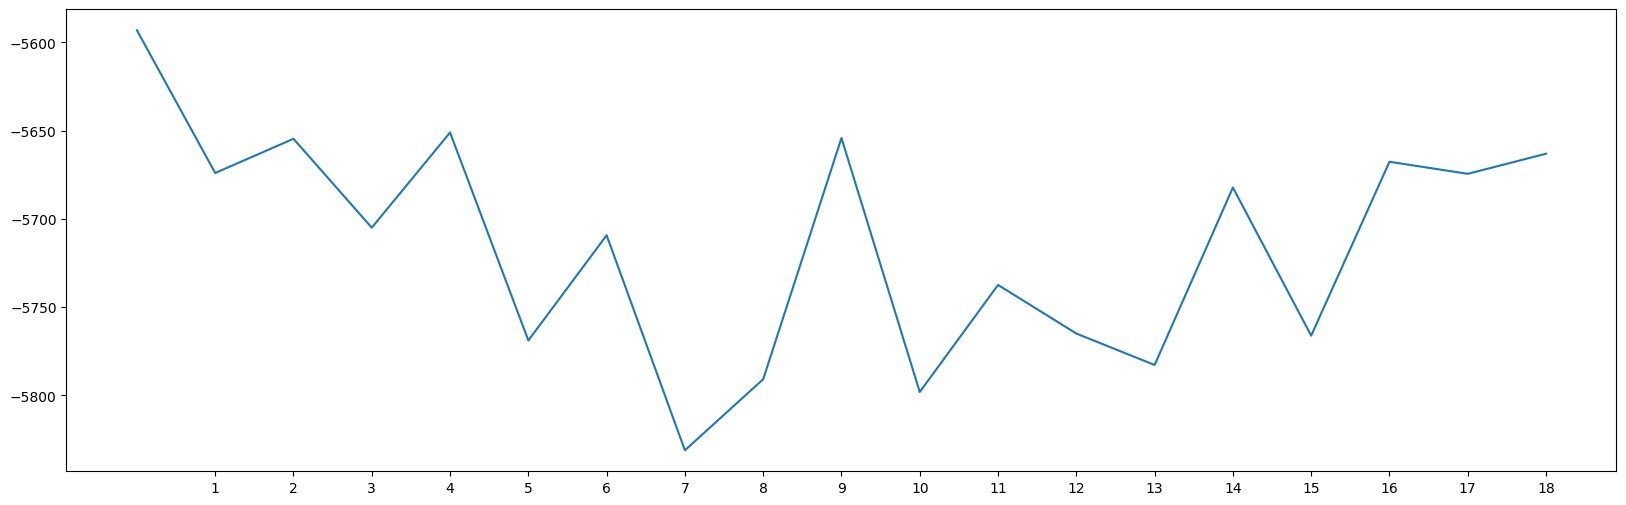

In [ ]:
from sklearn import cluster
from scipy.spatial import distance
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
import numpy as np

def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = kmeans.cluster_centers_
    #change the layering of array
    centerFinal = []
    for xi in range(kmeans.n_clusters):
      centerFix = []
      for fi in centers[xi]:
        centerFix.append(fi[0])
      centerFinal.append(centerFix)
    centers = [np.asarray(centerFinal)]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape
    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)



# IRIS DATA
iris = sklearn.datasets.load_iris()
X = np.asarray(newMultiSeries)[:,:,0]  # extract only the features
#Xs = StandardScaler().fit_transform(X)
Y = iris.target
ks = range(1,20)

# run 9 times kmeans and save each result in the KMeans object
#KMeans = [cluster.KMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
skip2 = True
if skip2:
  KMeans = [TimeSeriesKMeans(n_clusters=i, metric="euclidean", n_init=10).fit(X) for i in ks]
  BIC = [compute_bic(kmeansi,X) for kmeansi in KMeans]
  plt.xticks(ks)
  plt.plot(pd.DataFrame(BIC))